# Exploring Dandiset 000690: Visual Stimuli and Neural Responses in Mouse Visual System

> **Note**: This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results and verify findings with your own analysis when possible.

## Overview

This notebook provides an introduction to [DANDI:000690](https://dandiarchive.org/dandiset/000690/0.250326.0015), a dataset from the Allen Institute containing extracellular electrophysiological recordings of the mouse visual system during presentation of various visual stimuli.

The dataset includes:
- Spike-sorted neural data from Neuropixels probes
- Eye tracking measurements
- Running wheel activity
- Visual stimuli (templates and timing information)

In this notebook, we'll:
1. Access and explore the structure of the DANDI dataset
2. Examine the contents of representative NWB files
3. Visualize key data types (spike counts, stimulus frames, behavioral signals)
4. Demonstrate stimulus-spike alignment for neural analysis

## Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
import pynwb
from itertools import islice
import re

## Exploring the Dandiset Metadata

In [2]:
# Connect to DANDI and get dataset information
client = DandiAPIClient()
dandiset = client.get_dandiset("000690", "0.250326.0015")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/0.250326.0015


## Exploring Files in the Dandiset

In [3]:
# List all NWB files and classify into *_image.nwb (units/spikes) and others (likely LFP)
nwb_assets = list(dandiset.get_assets_by_glob("*.nwb"))

image_nwb = [a for a in nwb_assets if a.path.endswith('_image.nwb')]
other_nwb = [a for a in nwb_assets if not a.path.endswith('_image.nwb')]

def summarize_files(asset_list, label, n=5):
    print(f"First {min(len(asset_list), n)} {label} files:")
    for asset in islice(asset_list, n):
        size_mb = asset.size / 1024**2
        print(f"- {asset.path} ({size_mb:.1f} MB)")
    print(f"Total {label} files: {len(asset_list)}\n")

summarize_files(image_nwb, '*_image.nwb', 7)
summarize_files(other_nwb, 'other NWB', 5)

First 7 *_image.nwb files:
- sub-695762/sub-695762_ses-1317448357_image.nwb (7552.8 MB)
- sub-692072/sub-692072_ses-1298465622_image.nwb (6470.4 MB)
- sub-695435/sub-695435_ses-1309235849_image.nwb (6325.7 MB)
- sub-692077/sub-692077_ses-1300222049_image.nwb (6527.1 MB)
- sub-695763/sub-695763_ses-1317661297_image.nwb (7796.7 MB)
- sub-695764/sub-695764_ses-1311204385_image.nwb (7378.9 MB)
- sub-699321/sub-699321_ses-1312636156_image.nwb (7195.5 MB)
Total *_image.nwb files: 25

First 5 other NWB files:
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb (1606.2 MB)
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb (1700.1 MB)
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb (1569.8 MB)
- sub-692077/sub-692077_ses-1300222049_probe-0_ecephys.nwb (1673.3 MB)
- sub-692077/sub-692077_ses-1300222049.nwb (2335.5 MB)
Total other NWB files: 131



The listing above shows the file organization in this Dandiset. We can see two main file types:

- **`*_image.nwb` files**: These contain the spike-sorted units and are the primary source for single-unit and population analyses.
- **Other `*.nwb` files**: These are typically electrode-probe-specific LFP/extracellular ephys files and session-level metadata.

According to the dataset information, the `*_image.nwb` files contain the most relevant data for neural analysis, including spike-sorted units, while the other NWB files primarily contain LFP (local field potential) data.

Each recording session from a subject appears to have:
- One main `*_image.nwb` file containing spike data
- Several additional NWB files with probe-specific LFP data

Next, we'll examine a representative `*_image.nwb` file to understand the data structure.

## Examining NWB File Structure

Let's examine a single `*_image.nwb` file to understand its structure and contents. We'll use a representative file from the dataset.

In [4]:
# Connect to a specific NWB file using remote access (without downloading)
sample_file_path = "sub-695762/sub-695762_ses-1317448357_image.nwb"
asset = next(dandiset.get_assets_by_glob(sample_file_path))

remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Extract basic session information
general = {
    'identifier': nwb.identifier,
    'session_start_time': str(nwb.session_start_time),
    'subject_id': nwb.subject.subject_id,
    'subject_age_days': nwb.subject.age_in_days,
    'subject_sex': nwb.subject.sex,
    'subject_species': nwb.subject.species,
    'num_units': len(nwb.units.id[:]),
    'num_electrodes': len(nwb.electrodes.id[:]),
    'institution': getattr(nwb, 'institution', None),
    'stimulus_notes': getattr(nwb, 'stimulus_notes', None),
}

# Print session metadata
print("Session Information:")
for key, value in general.items():
    print(f"  {key}: {value}")

Session Information:
  identifier: 1317448357
  session_start_time: 2023-12-13 00:00:00-08:00
  subject_id: 695762
  subject_age_days: 141.0
  subject_sex: F
  subject_species: Mus musculus
  num_units: 1918
  num_electrodes: 1152
  institution: Allen Institute
  stimulus_notes: OpenScopeVision2Hippocampus


The file's metadata shows this is a session from an adult female mouse, with recordings from over 1900 spike-sorted units from 1152 electrodes.

Next, we'll look at the primary data structures and components in the file.

## Exploring Unit/Spike Data

First, let's examine the distribution of spike counts per unit to understand the neural yield and recording quality:

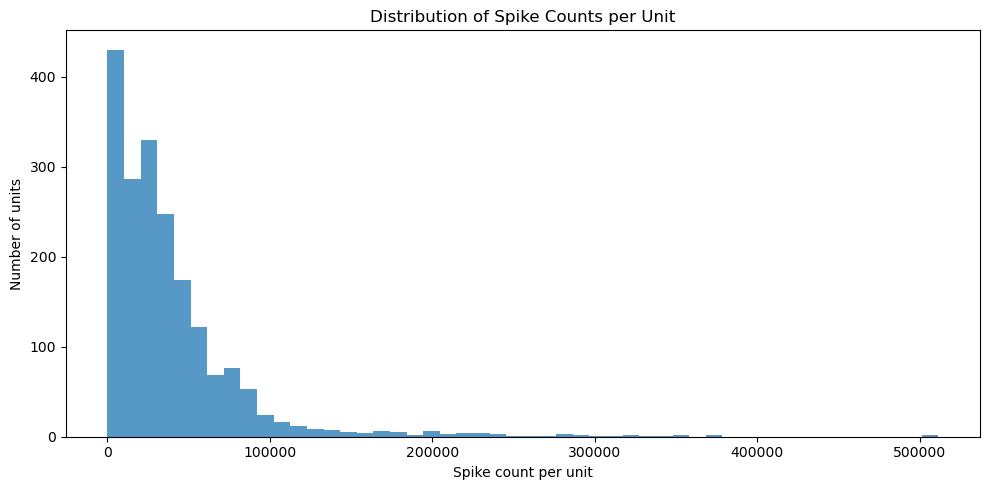

Total units: 1918
Mean spike count: 39099.3
Median spike count: 27612.0
Min spike count: 2
Max spike count: 511455


In [5]:
# Calculate spike count per unit
unit_ids = nwb.units.id[:]
spike_counts = np.array([len(nwb.units.spike_times_index[i]) for i in range(len(unit_ids))])

# Plot histogram of spike counts
plt.figure(figsize=(10, 5))
plt.hist(spike_counts, bins=50, color='tab:blue', alpha=0.75)
plt.xlabel('Spike count per unit')
plt.ylabel('Number of units')
plt.title('Distribution of Spike Counts per Unit')
plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"Total units: {len(unit_ids)}")
print(f"Mean spike count: {np.mean(spike_counts):.1f}")
print(f"Median spike count: {np.median(spike_counts):.1f}")
print(f"Min spike count: {np.min(spike_counts)}")
print(f"Max spike count: {np.max(spike_counts)}")

The histogram shows the distribution of spike counts across all units. Most units have spike counts in the lower range, with a tail of units showing very high spike counts. This is typical of Neuropixels recordings, reflecting different cell types, distances from electrodes, and possibly different neural regions.

## Exploring Visual Stimuli

This dataset contains detailed visual stimuli used in the experiment. Let's explore the stimulus templates and their presentation timing:

In [6]:
# List available stimulus templates and intervals
stim_templates = list(nwb.stimulus_template.keys())
stim_intervals = list(nwb.intervals.keys())

# Print available stimulus names (briefly)
print('Available stimulus templates (first 6):')
for name in stim_templates[:6]:
    print('-', name)
print('...')
print(f'Total templates: {len(stim_templates)}')

print('\nAvailable intervals (first 6):')
for name in stim_intervals[:6]:
    print('-', name)
print('...')
print(f'Total intervals: {len(stim_intervals)}')

Available stimulus templates (first 6):
- DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_scrambled_presentations
...
Total templates: 16

Available intervals (first 6):
- DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disco2SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Disk_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- Ring_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
- SAC_Wd15_Vel2_Bndry1_Cntst0_scrambled_presentations
...
Total intervals: 18


The dataset contains a rich set of visual stimuli and detailed timing information for their presentation. Let's visualize what one of these stimuli looks like:

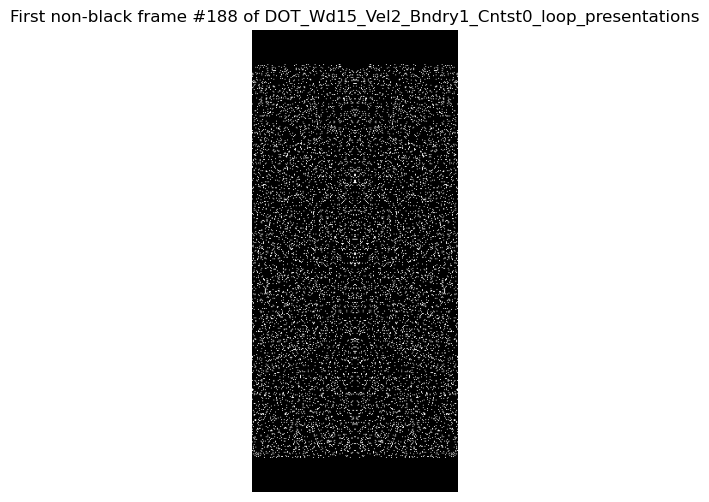

Stimulus shape: (960, 540, 240)


In [7]:
# Retrieve the stimulus template
stim_name = stim_templates[0]  # First stimulus for example
stim_data = nwb.stimulus_template[stim_name].data

# Find the first nonzero frame (for grayscale: any pixel >0)
for idx in range(stim_data.shape[0]):
    if np.any(stim_data[idx, :, :] > 0):
        frame_nonzero_idx = idx
        break
else:
    frame_nonzero_idx = 0  # fallback if all are zero

frame = stim_data[frame_nonzero_idx, :, :]

# Plot the first non-black frame
plt.figure(figsize=(8, 6))
plt.imshow(frame, cmap='gray')
plt.title(f'First non-black frame #{frame_nonzero_idx} of {stim_name}')
plt.axis('off')
plt.show()

print(f"Stimulus shape: {stim_data.shape}")

The image shows one frame of the stimulus template. The stimulus data is stored as a stack of frames, and the plot above shows the first non-black frame. The stimulus presentation often starts with black (no stimulus) frames before the actual visual content appears.

## Examining Stimulus Presentation Intervals

Now let's look at how the stimulus presentation timing information is structured:

In [8]:
# Select a stimulus interval to summarize
example_interval = stim_intervals[0]  # e.g. 'DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations'
interval_table = nwb.intervals[example_interval]

# Convert to dataframe and show first few rows
interval_df = interval_table.to_dataframe().head(10)
print(f'First 10 rows of stimulus interval: {example_interval}')
print(interval_df[['start_time', 'stop_time', 'frame', 'contrast', 'orientation']])

# Print column names
print('\nAll available columns in interval table:')
for col in interval_df.columns:
    print(f'- {col}')

First 10 rows of stimulus interval: DOT_Wd15_Vel2_Bndry1_Cntst0_loop_presentations
    start_time  stop_time  frame  contrast  orientation
id                                                     
0    985.15733  985.17400    0.0       1.0          0.0
1    985.17400  985.19068    1.0       1.0          0.0
2    985.19068  985.20736    2.0       1.0          0.0
3    985.20736  985.22404    3.0       1.0          0.0
4    985.22404  985.24074    4.0       1.0          0.0
5    985.24074  985.25741    5.0       1.0          0.0
6    985.25741  985.27408    6.0       1.0          0.0
7    985.27408  985.29077    7.0       1.0          0.0
8    985.29077  985.30745    8.0       1.0          0.0
9    985.30745  985.32413    9.0       1.0          0.0

All available columns in interval table:
- start_time
- stop_time
- stimulus_name
- stimulus_block
- frame
- color
- contrast
- opacity
- orientation
- size
- units
- stimulus_index
- tags
- timeseries


The interval table provides detailed timing information for each stimulus presentation, including:
- Start and stop times (in seconds from session start)
- Frame index within the stimulus
- Visual properties like contrast, orientation, color, etc.

This structure enables precise alignment of neural responses to specific visual stimuli.

## Exploring Behavioral Data

This dataset also includes behavioral data such as running wheel activity and eye tracking. Let's explore these:

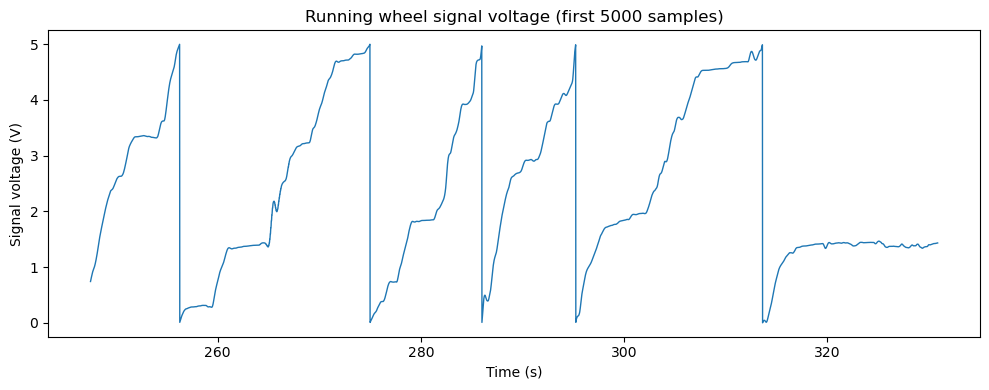

In [9]:
# Running wheel signal - extract a manageable segment
rw_signal = nwb.acquisition['running_wheel_signal_voltage']
rw_data = rw_signal.data[:5000]
rw_ts = rw_signal.timestamps[:5000]

plt.figure(figsize=(10, 4))
plt.plot(rw_ts, rw_data, lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Signal voltage (V)')
plt.title('Running wheel signal voltage (first 5000 samples)')
plt.tight_layout()
plt.show()

The running wheel data shows the mouse's movement behavior during the session. The periodic pattern likely reflects the rotation of the wheel as the animal runs.

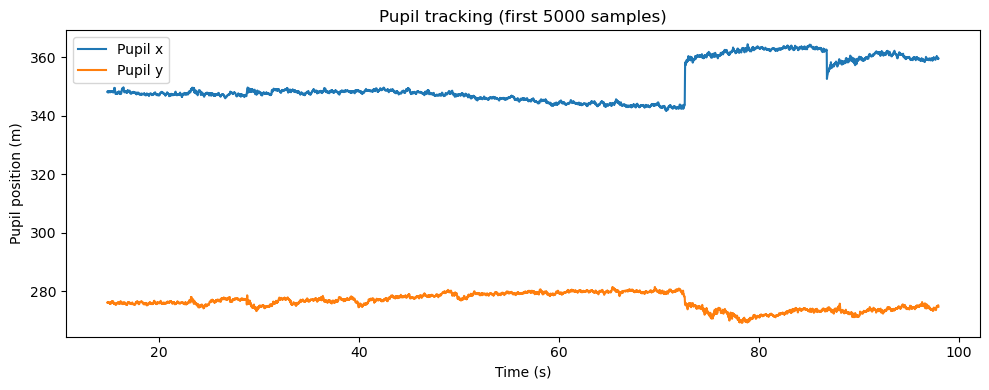

In [10]:
# Eye tracking - extract segment and plot x/y pupil position
pupil_tracking = nwb.acquisition['EyeTracking'].pupil_tracking
eyepos = pupil_tracking.data[:5000]
eyets = pupil_tracking.timestamps[:5000]

plt.figure(figsize=(10, 4))
plt.plot(eyets, eyepos[:, 0], label='Pupil x')
plt.plot(eyets, eyepos[:, 1], label='Pupil y')
plt.xlabel('Time (s)')
plt.ylabel('Pupil position (m)')
plt.title('Pupil tracking (first 5000 samples)')
plt.legend()
plt.tight_layout()
plt.show()

The eye tracking data shows the horizontal (x) and vertical (y) position of the mouse's pupil over time, allowing researchers to track eye movements and gaze direction.

## Accessing Spike Times and Aligning with Stimuli

Finally, let's demonstrate how to access spike times for a specific unit and align them with stimulus presentations:

In [11]:
# Choose a unit ID to explore (first unit)
first_unit_id = unit_ids[0]

# Get spike times for this unit
spike_times = nwb.units.spike_times_index[0]

print(f'Example spike times for unit {first_unit_id} (first 10):')
print(spike_times[:10])
print(f'Total spikes for this unit: {len(spike_times)}')

# Align spikes to an example stimulus presentation window
example_interval = list(nwb.intervals.keys())[0]
interval_table = nwb.intervals[example_interval]
interval_df = interval_table.to_dataframe().head(1)

stim_start = interval_df.iloc[0]["start_time"]
stim_stop = interval_df.iloc[0]["stop_time"]

# Spike times during first presentation
spikes_in_interval = spike_times[(spike_times >= stim_start) & (spike_times < stim_stop)]
print(f'Number of spikes for unit {first_unit_id} during first presentation ({stim_start:.3f}-{stim_stop:.3f} s): {len(spikes_in_interval)}')
if len(spikes_in_interval) > 0:
    print('Spikes (s):', spikes_in_interval)
else:
    print('(No spikes)')

Example spike times for unit 9 (first 10):
[20.14667131 20.235471   20.55783655 20.62730298 20.68956943 20.81560233
 21.09126805 21.10580133 21.24293419 21.25903413]
Total spikes for this unit: 104526


Number of spikes for unit 9 during first presentation (985.157-985.174 s): 0
(No spikes)


This example demonstrates how to:
1. Extract spike times for a specific unit
2. Identify a stimulus presentation interval
3. Filter spikes that occur during that interval

This is the foundation for more complex analyses like:
- Computing peri-stimulus time histograms
- Analyzing population responses to specific stimuli
- Correlating neural activity with behavioral state

## Summary

In this notebook, we've explored DANDI:000690, which contains extracellular recordings from the mouse visual system during presentation of various visual stimuli.

We've learned how to:
- Access and navigate the DANDI dataset
- Examine the structure of NWB files
- Explore spiking activity of neural units
- Visualize stimulus content and presentation timing
- Access behavioral signals like running and eye tracking
- Align neural activity with stimulus presentations

This dataset provides rich opportunities for studying visual processing, neural coding, and behavior-neural interactions in the mouse visual system. Possible next steps include:
- Computing tuning curves for visual features
- Analyzing population coding of visual stimuli
- Examining the relationship between running speed and neural activity
- Investigating eye movement responses to specific stimuli